<a href="https://colab.research.google.com/github/pakaji93/Data_Science_Project/blob/main/Data_Science_Project_5_Gandhung_Wicaksono.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation

## Background

This dataset contains all purchases made for an online retail company based in the UK during an eight month period. We could use cluster analysis combined with RFM analysis to do a customer segmentation.

## Prepare and Explore the Data

For this experiment, we will use [this](https://www.kaggle.com/vijayuv/onlineretail) data from Kaggle platform.

In [ ]:
# Package imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', None)

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/SkolaClass_DataScience/Week 12/OnlineRetail.csv"
df = pd.read_csv(path, encoding= 'unicode_escape')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Since we want to segment our customers, we have to make sure that `CustomerID` is not null.

In [ ]:
# Check missing value
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

We could see that there is missing value in `CustomerID` columns. We could remove those missing values.

In [ ]:
# Remove missing value
df = df[df["CustomerID"].notna()]

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Then we could do some descriptive statistic.

In [ ]:
# Simple descriptive statistic
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Wait, hold on. How come the quantity is a negative number and the unit price is zero? Let's check it.

In [ ]:
# Check anomaly data
quantity_zero = len(df[df["Quantity"] <= 0])
perc_quantity_zero = (len(df[df["Quantity"] <= 0]) / len(df)) * 100
unitprice_zero = len(df[df["UnitPrice"] == 0])
perc_unitprice_zero = (len(df[df["UnitPrice"] == 0]) / len(df)) * 100

print("The data consist of", str(quantity_zero), "rows of data with item quantity less/equal than zero.")
print("About {:.2f}% of total data".format(perc_quantity_zero))
print("")
print("The data consist of", str(unitprice_zero), "rows of data with unit price equal to zero.")
print("About {:.2f}% of total data".format(perc_unitprice_zero))

The data consist of 8905 rows of data with item quantity less/equal than zero.
About 2.19% of total data

The data consist of 40 rows of data with unit price equal to zero.
About 0.01% of total data


Then just remove those anomaly data

In [ ]:
# Remove anomaly
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


Now we're good to go. Lets do some data exploration!

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  object 
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  float64
 7   Country      397884 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.3+ MB


The data contains 397884 rows and 8 columns, each row represents each item in a purchasement. The columns are:
* `InvoiceNo` - Invoice number, to identify each invoice
* `StockCode` - Stock code, to identify each item in the inventory
* `Description` - Item's description
* `Quantity` - Number of purchased item in each invoice
* `InvoiceDate` - Date of purchasement
* `UnitPrice` - Item's price per unit
* `CustomerID` - Customer's identification number
* `Country` - Customer's country of origin

In [ ]:
# Check unique value
df[['InvoiceNo', 'StockCode', 'CustomerID', 'Country']].nunique()

InvoiceNo     18532
StockCode      3665
CustomerID     4338
Country          37
dtype: int64

There are 18532 purchasements, 3665 unique item purchased, from 4338 customers that came from 37 countries.

As we seen above, there are 37 countries of customer's origin. Since the retail company is based in the UK, we could simplified the country as UK or Non UK

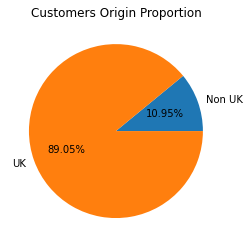

In [ ]:
# Simplify country origin
df['Country_isUK'] = np.where(df['Country'] == 'United Kingdom', 'UK', 'Non UK')

customers_origin = df.groupby(['Country_isUK']).size()

_ = plt.title('Customers Origin Proportion')
_ = plt.pie(customers_origin, labels = customers_origin.index, autopct = lambda p: f'{p:.2f}%')
plt.show()

Based on the piechart, we could see that mostly our customers are from the UK.

Next, we could analyze the trend of purchasement. First, lets create `TotalAmount` column (`Quantity` * `UnitPrice`). Then, we could transform the `InvoiceDate` data type from string to date.

In [ ]:
# Create new features and cast date column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


Then plot the trendline.

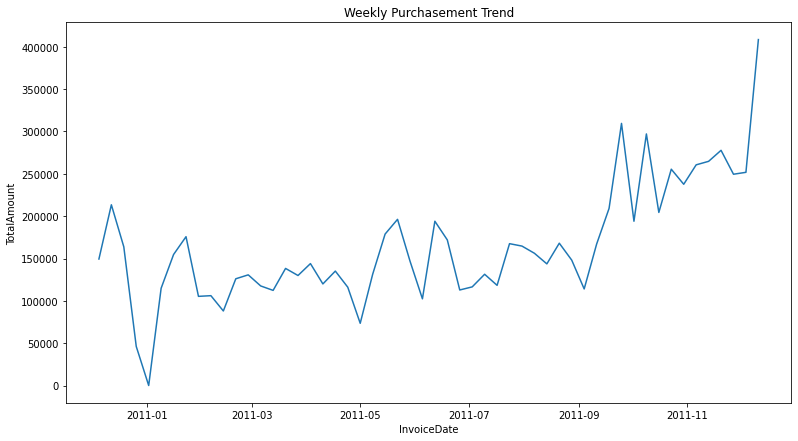

In [ ]:
# Plot weekly trend
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

_ = plt.figure(figsize=(13, 7))  
_ = plt.title('Weekly Purchasement Trend')
_ = sns.lineplot(x = weekly_purchasements.index, y = weekly_purchasements)
plt.show()

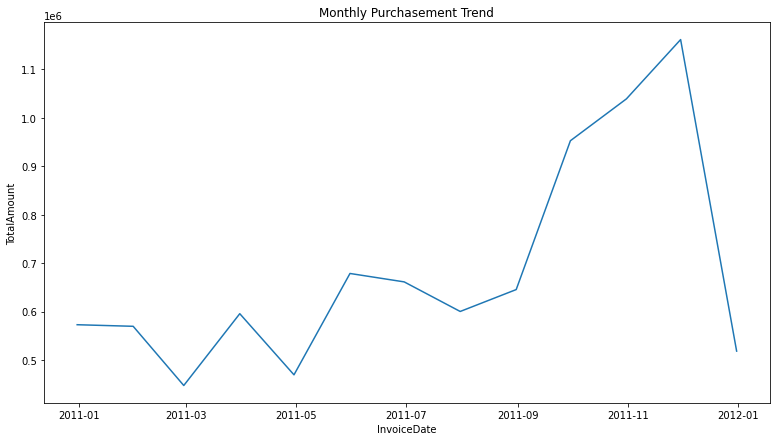

In [ ]:
# Plot monthly trend
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

_ = plt.figure(figsize=(13, 7))  
_ = plt.title('Monthly Purchasement Trend')
_ = sns.lineplot(x = monthly_purchasements.index, y = monthly_purchasements)
plt.show()

Based on the picture above, it can be seen that there was an increase in total purchases at the end of the year.

## RFM

In this project, we would segment the customers using customer's demography and purchasement behavior. To explain the customer's demography, we could use `Country` column while to explain the customer's purchasement behavior we have to transform our data first to get those information. We could use RFM analysis to get those information.

### Recency

To measure customer's recency, we could substract the latest transaction date in the data with each customer's latest transaction.

In [ ]:
# Get customer's recency
recency = df.groupby(['CustomerID'])['InvoiceDate'].max()
recency = max(recency) - recency
recency = recency.dt.days
recency = recency.rename('Recency')

recency.head()

CustomerID
12346.0    325
12347.0      1
12348.0     74
12349.0     18
12350.0    309
Name: Recency, dtype: int64

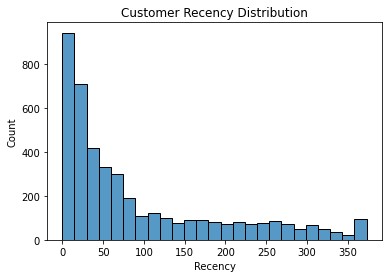

In [ ]:
# Recency histogram plot
_ = plt.title('Customer Recency Distribution')
_ = sns.histplot(recency)
plt.show()

### Frequency

To measure customer's frequency, we could count customer's invoice.

In [ ]:
# Count frequency
frequency = df.groupby(['CustomerID'])['InvoiceNo'].count()
frequency = frequency.rename('Frequency')

frequency.head()

CustomerID
12346.0      1
12347.0    182
12348.0     31
12349.0     73
12350.0     17
Name: Frequency, dtype: int64

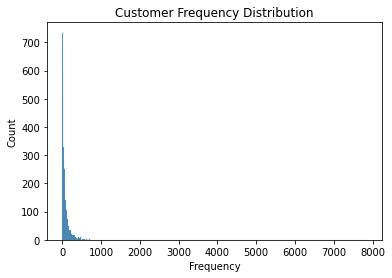

In [ ]:
# Frequency histogram plot
_ = plt.title('Customer Frequency Distribution')
_ = sns.histplot(frequency)
plt.show()

### Monetary

To measure customer's monetary, we could sum the customer's total purchasements.

In [ ]:
# Sum the money spent
monetary = df.groupby(['CustomerID'])['TotalAmount'].sum()
monetary = monetary.rename('Monetary')

monetary.head()

CustomerID
12346.0    77183.60
12347.0     4310.00
12348.0     1797.24
12349.0     1757.55
12350.0      334.40
Name: Monetary, dtype: float64

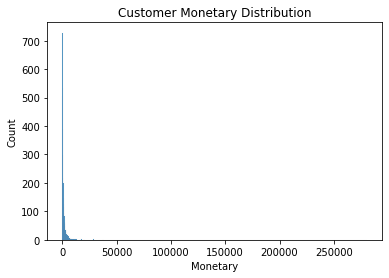

In [ ]:
# Monetary histogram plot
_ = plt.title('Customer Monetary Distribution')
_ = sns.histplot(monetary)
plt.show()

### Merge the Data

The data could be separated into two dataframes. The first dataframe (log transformed data) supposed to be used when modeling and the second one (without log transformation) could be used when visualize the result.

In [ ]:
# Get customer's country of origin
country = df.groupby(['CustomerID', 'Country_isUK']).size().reset_index().drop(0, axis = 1)

# Merge the data
df_new = country \
    .merge(recency, on = 'CustomerID') \
    .merge(frequency, on = 'CustomerID') \
    .merge(monetary, on = 'CustomerID')

# Set CustomerID as index
df_new = df_new.set_index('CustomerID')

df_new.head()

,Country_isUK,Recency,Frequency,Monetary
CustomerID,,,,
12346.0,UK,325,1,77183.60
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40


### One Hot Encoding

Since our model could just accept the numeric value, we have to recode the non numeric column.

In [ ]:
# Recode the non numeric variable
df_ohe = df_new.copy()

df_new_ohe = pd.get_dummies(df_ohe, columns=['Country_isUK'], drop_first=True)
df_new_ohe = df_new_ohe.rename(columns = {'Country_isUK_UK': 'Country_UK'})

df_new_ohe.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,1,182,4310.00,0
12348.0,74,31,1797.24,0
12349.0,18,73,1757.55,0
12350.0,309,17,334.40,0


### Scaling

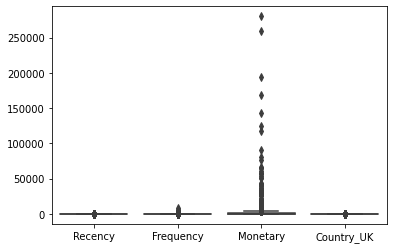

In [ ]:
_ = sns.boxplot(data = df_new_ohe)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [ ]:
# Scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new_ohe)

df_scaled = pd.DataFrame(df_scaled, columns = df_new_ohe.columns, index = df_new_ohe.index)

df_scaled.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,2.334574,-0.396578,8.358668,0.326547
12347.0,-0.905340,0.394649,0.250966,-3.062350
12348.0,-0.175360,-0.265435,-0.028596,-3.062350
12349.0,-0.735345,-0.081836,-0.033012,-3.062350
12350.0,2.174578,-0.326635,-0.191347,-3.062350


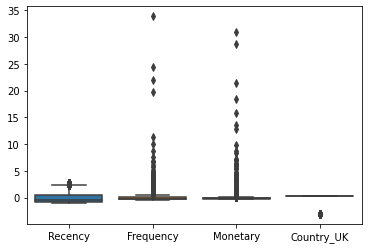

In [ ]:
# Plot scaled data
_ = sns.boxplot(data = df_scaled)
plt.show()

## Modeling

In [ ]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters = k, random_state = 123).fit(df_scaled)
    
    silhouette.append(silhouette_score(X = df_scaled, labels = kmeans.labels_))

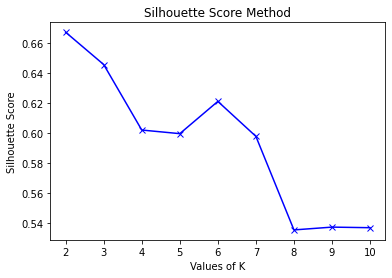

In [ ]:
# Plot the score
plt.plot(possible_k, silhouette, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

Using silhouette score, the best K is either 2 or 6

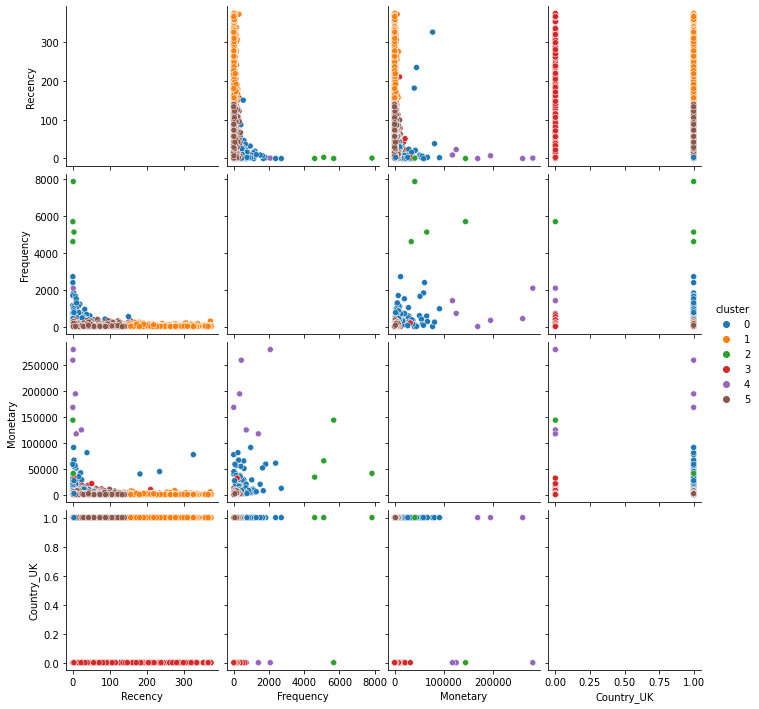

In [ ]:
kmeans = KMeans(n_clusters = 6, random_state = 123).fit(df_scaled)

df_result_kmeans = df_new_ohe.copy()
df_result_kmeans['cluster'] = kmeans.labels_

_ = sns.pairplot(data = df_result_kmeans, hue = 'cluster', diag_kind = 'None', palette = 'tab10')
plt.show()

In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
df_result_kmeans \
    .drop("Country_UK", axis = 1) \
    .groupby('cluster') \
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max', 'count']) \
    .transpose()

cluster                      0            1              2             3  \
Recency   mean       15.234973   246.776618       1.000000     95.405797   
          std        35.305176    65.636727       1.414214    104.638705   
          min         0.000000   143.000000       0.000000      0.000000   
          q25         2.000000   189.000000       0.000000     18.000000   
          median      6.000000   242.000000       0.500000     52.000000   
          q75        16.000000   296.000000       1.500000    136.500000   
          max       325.000000   373.000000       3.000000    373.000000   
          count     183.000000   958.000000       4.000000    414.000000   
Frequency mean      535.360656    27.689979    5807.000000     81.396135   
          std       358.078267    32.176026    1429.730044     96.304061   
          min         1.000000     1.000000    4595.000000      1.000000   
          q25       367.000000     8.250000    4982.000000     21.250000   
          median    450.000000    18.000000    5393.000000     45.000000   
          q75       589.500000    33.000000    6218.000000    101.000000   
          max      2700.000000   297.000000    7847.000000    638.000000   
          count     183.000000   958.000000       4.000000    414.000000   
Monetary  mean    13085.065738   450.793070   70925.287500   2262.538913   
          std     16313.461152   610.367153   50424.336433   3479.689136   
          min      1093.650000     3.750000   33719.730000     51.560000   
          q25      4014.945000   163.225000   39173.610000    459.650000   
          median   6923.130000   305.515000   53078.180000   1025.700000   
          q75     13213.210000   505.542500   84829.857500   2659.962500   
          max     91062.380000  7832.470000  143825.060000  31906.820000   
          count     183.000000   958.000000       4.000000    414.000000   

cluster                       4             5  
Recency   mean         6.666667     42.676884  
          std          8.869423     36.313016  
          min          0.000000      0.000000  
          q25          0.250000     14.000000  
          median       4.000000     31.000000  
          q75          8.500000     64.000000  
          max         23.000000    155.000000  
          count        6.000000   2773.000000  
Frequency mean       826.833333     76.270826  
          std        771.620481     74.030983  
          min          3.000000      1.000000  
          q25        360.500000     22.000000  
          median     572.500000     51.000000  
          q75       1228.500000    107.000000  
          max       2076.000000    385.000000  
          count        6.000000   2773.000000  
Monetary  mean    190863.461667   1341.293935  
          std      67791.993010   1592.871914  
          min     117379.630000      6.200000  
          q25     135804.022500    371.700000  
          median  181511.645000    795.120000  
          q75     243380.672500   1720.300000  
          max     280206.020000  17654.540000  
          count        6.000000   2773.000000

In [ ]:
df_result_kmeans["recency_score"] = pd.qcut(df_result_kmeans['Recency'], 5, labels=[5, 4, 3, 2, 1])
df_result_kmeans["frequency_score"] = pd.qcut(df_result_kmeans['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
# 1 1,1,2,3,3,3,3,3,
df_result_kmeans["monetary_score"] = pd.qcut(df_result_kmeans['Monetary'], 5, labels=[1, 2, 3, 4, 5])
df_result_kmeans["RFM_SCORE"] = (df_result_kmeans['recency_score'].astype(str) +
                    df_result_kmeans['frequency_score'].astype(str))
df_result_kmeans.head()

,Recency,Frequency,Monetary,Country_UK,cluster,recency_score,frequency_score,monetary_score,RFM_SCORE
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,1,0,1,1,5,11
12347.0,1,182,4310.00,0,3,5,5,5,55
12348.0,74,31,1797.24,0,3,2,3,4,23
12349.0,18,73,1757.55,0,3,4,4,4,44
12350.0,309,17,334.40,0,3,1,2,2,12


In [ ]:
df_result_kmeans.groupby(["cluster"])["RFM_SCORE"].agg({'min', 'max', 'median'})

,median,min,max
cluster,,,
0,55.0,11,55
1,12.0,11,25
2,55.0,55,55
3,33.0,11,55
4,55.0,45,55
5,41.0,21,55


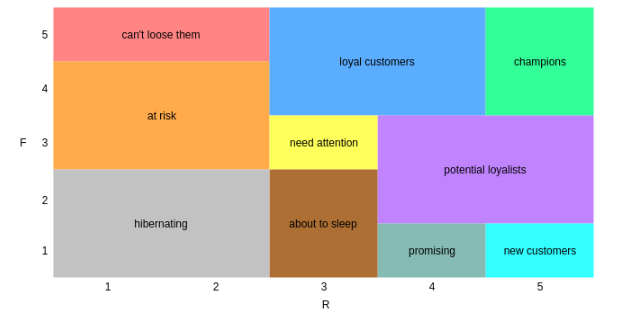



Karateristik Customer (berdasarkan diagram RFM diatas) :
1. Cluster 0 : **Champions - Hibernating**

   - Terdapat 183 Customers
   - Lama tidak berbelanja selama 15.23 hari
   - Avg belanja sebanyak 535.36 kali
   - Avg pengeluaran sebanyak 13085.06 dolar

   Promo yang tepat untuk cluster 0 : 
   - For Champions : Dapat diberikan reward seperti spesial diskon di hari ulang tahun
   - For Hibernating : Dapat diberikan aktivasi/campaign agar mereka dapat kembali lebih sering

2. Cluster 1 : **Hibernating - Can't Lose Them**

   - Terdapat 958 Customers
   - Lama tidak berbelanja selama 246.78 hari
   - Avg belanja sebanyak 27.68 kali
   - Avg pengeluaran sebanyak 450.79 dolar
   
   Promo yang tepat untuk cluster 1 :
   - For Hibernating : Dapat diberikan aktivasi/campaign agar mereka dapat kembali lebih sering
   - For Can't Lose Them : Harus memberikan ekstra perhatian terhadap mereka, bisa dengan cara memberikan rekomendasi produk baru, spesial promosi dan cashback untuk pembelanjaan

3. Cluster 2 : **Champions**

   - Terdapat 4 Customers
   - Lama tidak berbelanja selama 1 hari
   - Avg belanja sebanyak 5807 kali
   - Avg pengeluaran sebanyak 70925.47 dolar
   
   Promo yang tepat untuk cluster 2 :
   - For Champions : Dapat diberikan reward seperti spesial diskon di hari ulang tahun

4. Cluster 3 : **Champions - Hibernating**

   - Terdapat 414 Customers
   - Lama tidak berbelanja selama 95.40 hari
   - Avg belanja sebanyak 81.39 kali
   - Avg pengeluaran sebanyak 2262.54 dolar
   
   Promo yang tepat untuk cluster 3 :
   - For Champions : Dapat diberikan reward seperti spesial diskon di hari ulang tahun

5. Cluster 4 : **Champions - Loyal Customer**

   - Terdapat 6 Customers
   - Lama tidak berbelanja selama 6.67 hari
   - Avg belanja sebanyak 826.23 kali
   - Avg pengeluaran sebanyak 190863.46 dolar
   
   Promo yang tepat untuk cluster 4 :
   - For Champions : Dapat diberikan reward seperti spesial diskon di hari ulang tahun
   - For Loyal Customer : Dapat diberikan penawaran seperti program membership/loyalty, subscription dsb

6. Cluster 5 : **Champions - Hibernating**

   - Terdapat 2773 Customers
   - Lama tidak berbelanja selama 42.68 hari
   - Avg belanja sebanyak 76.27 kali
   - Avg pengeluaran sebanyak 1341.29 dolar
   
   Promo yang tepat untuk cluster 5 :
   - For Champions : Dapat diberikan reward seperti spesial diskon di hari ulang tahun
   - For Hibernating : Dapat diberikan aktivasi/campaign agar mereka dapat kembali lebih sering

That's it! The customer's behavior really segmented by their country of origin.

What if we separate the customer by its country of origin before doing cluster analysis?

#Karateristik Customer Non-UK

In [ ]:
df_nuk = df_new[df_new['Country_isUK'] != 'UK']

df_nuk.head()

,Country_isUK,Recency,Frequency,Monetary
CustomerID,,,,
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40
12352.0,Non UK,35,85,2506.04


In [ ]:
df_nuk = df_nuk.drop(columns=['Country_isUK']).copy()

df_nuk.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40
12352.0,35,85,2506.04


In [ ]:
# Scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_nuk)

df_scaled = pd.DataFrame(df_scaled, columns = df_nuk.columns, index = df_nuk.index)

df_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,-0.896621,0.248302,0.026983
12348.0,-0.197122,-0.233730,-0.115746
12349.0,-0.733724,-0.099655,-0.118001
12350.0,2.054690,-0.278422,-0.198838
12352.0,-0.570827,-0.061348,-0.075485


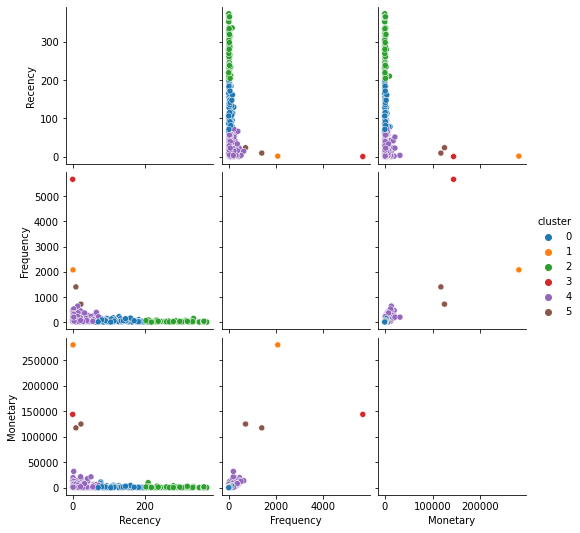

In [ ]:
kmeans = KMeans(n_clusters = 6, random_state = 123).fit(df_scaled)

df_result_kmeans_2 = df_nuk.copy()
df_result_kmeans_2['cluster'] = kmeans.labels_

_ = sns.pairplot(data = df_result_kmeans_2, hue = 'cluster', diag_kind = 'None', palette = 'tab10')
plt.show()

In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
df_result_kmeans_2 \
    .groupby('cluster') \
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max', 'count']) \
    .transpose()

/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


cluster                      0          1            2          3  \
Recency   mean      108.684685       1.00   289.285714       0.00   
          std        38.250842        NaN    49.965213        NaN   
          min        58.000000       1.00   203.000000       0.00   
          q25        77.000000       1.00   242.000000       0.00   
          median     99.000000       1.00   290.000000       0.00   
          q75       134.000000       1.00   329.000000       0.00   
          max       197.000000       1.00   373.000000       0.00   
          count     111.000000       1.00    77.000000       1.00   
Frequency mean       45.126126    2076.00    24.909091    5675.00   
          std        38.947078        NaN    24.089844        NaN   
          min         2.000000    2076.00     1.000000    5675.00   
          q25        21.000000    2076.00    10.000000    5675.00   
          median     34.000000    2076.00    18.000000    5675.00   
          q75        53.500000    2076.00    28.000000    5675.00   
          max       219.000000    2076.00   149.000000    5675.00   
          count     111.000000       1.00    77.000000       1.00   
Monetary  mean     1218.059910  280206.02   816.680000  143825.06   
          std      1500.519510        NaN  1287.578996        NaN   
          min        51.560000  280206.02    63.000000  143825.06   
          q25       439.010000  280206.02   218.450000  143825.06   
          median    803.560000  280206.02   415.700000  143825.06   
          q75      1299.145000  280206.02   889.240000  143825.06   
          max     11072.670000  280206.02  9864.260000  143825.06   
          count     111.000000       1.00    77.000000       1.00   

cluster                      4              5  
Recency   mean       22.827434      16.000000  
          std        17.246484       9.899495  
          min         0.000000       9.000000  
          q25         8.000000      12.500000  
          median     21.000000      16.000000  
          q75        33.750000      19.500000  
          max        72.000000      23.000000  
          count     226.000000       2.000000  
Frequency mean      118.455752    1057.000000  
          std       113.867214     485.075252  
          min         2.000000     714.000000  
          q25        36.000000     885.500000  
          median     83.500000    1057.000000  
          q75       161.000000    1228.500000  
          max       638.000000    1400.000000  
          count     226.000000       2.000000  
Monetary  mean     3268.150885  121147.080000  
          std      4277.292021    5327.978886  
          min        91.680000  117379.630000  
          q25       723.802500  119263.355000  
          median   1804.930000  121147.080000  
          q75      3981.195000  123030.805000  
          max     31906.820000  124914.530000  
          count     226.000000       2.000000

In [ ]:
df_result_kmeans_2["recency_score"] = pd.qcut(df_result_kmeans_2['Recency'], 5, labels=[5, 4, 3, 2, 1])
df_result_kmeans_2["frequency_score"] = pd.qcut(df_result_kmeans_2['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
# 1 1,1,2,3,3,3,3,3,
df_result_kmeans_2["monetary_score"] = pd.qcut(df_result_kmeans_2['Monetary'], 5, labels=[1, 2, 3, 4, 5])
df_result_kmeans_2["RFM_SCORE"] = (df_result_kmeans_2['recency_score'].astype(str) +
                    df_result_kmeans_2['frequency_score'].astype(str))
df_result_kmeans_2.head()

,Recency,Frequency,Monetary,cluster,recency_score,frequency_score,monetary_score,RFM_SCORE
CustomerID,,,,,,,,
12347.0,1,182,4310.00,4,5,5,5,55
12348.0,74,31,1797.24,0,2,2,4,22
12349.0,18,73,1757.55,4,4,4,4,44
12350.0,309,17,334.40,2,1,1,1,11
12352.0,35,85,2506.04,4,3,4,4,34


In [ ]:
df_result_kmeans_2.groupby(["cluster"])["RFM_SCORE"].agg({'min', 'max', 'median'})

,median,min,max
cluster,,,
0,23.0,11,34
1,55.0,55,55
2,11.0,11,15
3,55.0,55,55
4,44.0,31,55
5,50.0,45,55


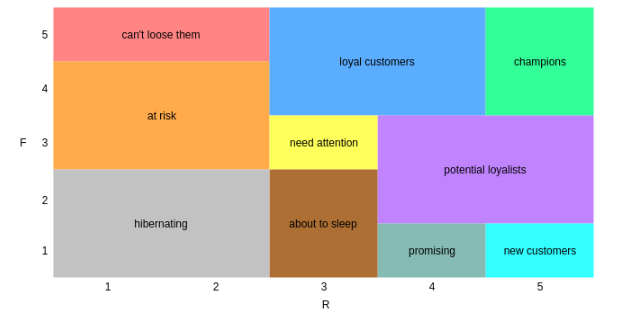

*Jika nilai recency dan frequency rendah, maka ranking pada diagram ini tinggi

Karateristik Customer non UK (berdasarkan diagram RFM diatas) :
1. Cluster 0 : **Loyal Customer - Hibernating**

   - Terdapat 111 Customers
   - Lama tidak berbelanja selama 108.68 hari
   - Avg belanja sebanyak 45.13 kali
   - Avg pengeluaran sebanyak 1218.06 dolar

   Promo yang tepat untuk cluster 0 : 
   - For Loyal Customer : Dapat diberikan penawaran seperti program membership/loyalty, subscription dsb
   - For Hibernating : Dapat diberikan aktivasi/campaign agar mereka dapat kembali lebih sering

2. Cluster 1 : **Champions**

   - Terdapat 1 Customers
   - Lama tidak berbelanja selama 1 hari
   - Avg belanja sebanyak 2076.00 kali
   - Avg pengeluaran sebanyak 280206.02 dolar
   
   Promo yang tepat untuk cluster 1 :
   - For Champions : Dapat diberikan reward seperti spesial diskon di hari ulang tahun

3. Cluster 2 : **Hibernating - Can't Lose Them**

   - Terdapat 77 Customers
   - Lama tidak berbelanja selama 289.29 hari
   - Avg belanja sebanyak 24.90 kali
   - Avg pengeluaran sebanyak 826.68 dolar
   
   Promo yang tepat untuk cluster 2 :
   - For Hibernating : Dapat diberikan aktivasi/campaign agar mereka dapat kembali lebih sering
   - For Can't Lose Them : Harus memberikan ekstra perhatian terhadap mereka, bisa dengan cara memberikan rekomendasi produk baru, spesial promosi dan cashback untuk pembelanjaan

4. Cluster 3 : **Champions**

   - Terdapat 1 Customers
   - Lama tidak berbelanja selama 0 hari
   - Avg belanja sebanyak 5675 kali
   - Avg pengeluaran sebanyak 143825.06 dolar
   
   Promo yang tepat untuk cluster 3 :
   - For Champions : Dapat diberikan reward seperti spesial diskon di hari ulang tahun

5. Cluster 4 : **Champions - About to Sleep**

   - Terdapat 226 Customers
   - Lama tidak berbelanja selama 22.83 hari
   - Avg belanja sebanyak 118.46 kali
   - Avg pengeluaran sebanyak 3268.15 dolar
   
   Promo yang tepat untuk cluster 4 :
   - For Champions : Dapat diberikan reward seperti spesial diskon di hari ulang tahun
   - For About to Sleep : Kita harus tetap berinteraksi dengan customer ini, dapat diberikan promo diskon untuk produk-produk popular

6. Cluster 5 : **Champions - Loyal Customer**

   - Terdapat 2 Customers
   - Lama tidak berbelanja selama 16 hari
   - Avg belanja sebanyak 1057.00 kali
   - Avg pengeluaran sebanyak 121147.08 dolar
   
   Promo yang tepat untuk cluster 5 :
   - For Champions : Dapat diberikan reward seperti spesial diskon di hari ulang tahun
   - For Loyal Customer : Dapat diberikan penawaran seperti program membership/loyalty, subscription dsb

#Explore more EDA

##Top 5 most spender

In [ ]:
df_new.head()

,Country_isUK,Recency,Frequency,Monetary
CustomerID,,,,
12346.0,UK,325,1,77183.60
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40


In [ ]:
df_eda = df_new.copy()

df_eda = df_eda.groupby(level='CustomerID').agg({'Recency':'max', 'Frequency':'max', 'Monetary':'sum'}).sort_values(by='Monetary', ascending=False)

df_eda.head()

,Recency,Frequency,Monetary
CustomerID,,,
14646.0,1,2076,280206.02
18102.0,0,431,259657.30
17450.0,7,337,194550.79
16446.0,0,3,168472.50
14911.0,0,5675,143825.06


##Customer traffic by Month / Week / Day / Time

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


In [ ]:
df['Month Year'] = df['InvoiceDate'].dt.strftime('%Y-%m')
df['Week'] = df['InvoiceDate'].dt.strftime('%W')
df['Day'] = df['InvoiceDate'].dt.strftime('%u')
df['Time'] = df['InvoiceDate'].dt.strftime('%X')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount,Month Year,Week,Day,Time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30,2010-12,48,3,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34,2010-12,48,3,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00,2010-12,48,3,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34,2010-12,48,3,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34,2010-12,48,3,08:26:00


In [ ]:
df_eda = df[['CustomerID', 'Month Year', 'Week', 'Day', 'Time']]

df_eda.head()

,CustomerID,Month Year,Week,Day,Time
0,17850.0,2010-12,48,3,08:26:00
1,17850.0,2010-12,48,3,08:26:00
2,17850.0,2010-12,48,3,08:26:00
3,17850.0,2010-12,48,3,08:26:00
4,17850.0,2010-12,48,3,08:26:00


In [ ]:
df_eda_m = df_eda.groupby(['Month Year'])['CustomerID'].count()

df_eda_m.head()

Month Year
2010-12    26157
2011-01    21229
2011-02    19927
2011-03    27175
2011-04    22642
Name: CustomerID, dtype: int64

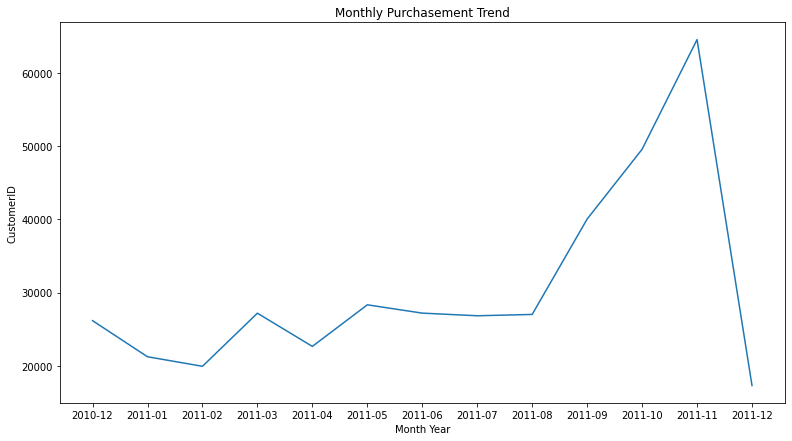

In [ ]:
monthly_purchasements = df_eda_m.copy()

_ = plt.figure(figsize=(13, 7))  
_ = plt.title('Monthly Purchasement Trend')
_ = sns.lineplot(x = monthly_purchasements.index, y = monthly_purchasements)
plt.show()

Dari data diatas dapat dilihat bahwa bulan dengan banyak Customer terbanyak ada di bulan :
1. November
2. Oktober
3. September

In [ ]:
df_eda_w = df_eda.groupby(['Week'])['CustomerID'].count()

df_eda_w.head()

Week
01    5228
02    4704
03    4679
04    5618
05    5080
Name: CustomerID, dtype: int64

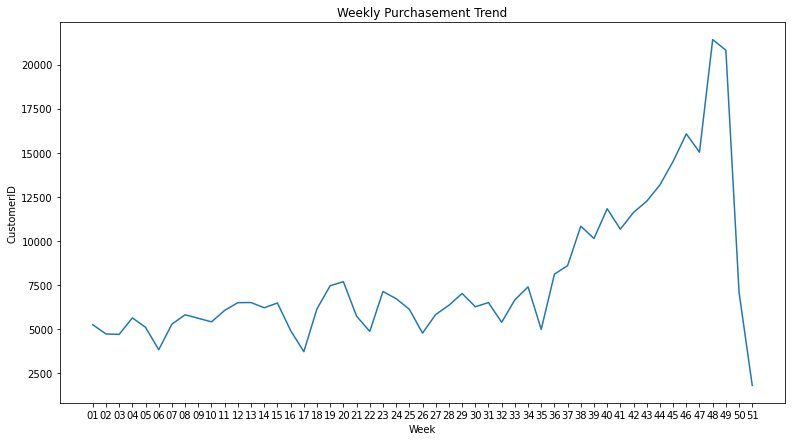

In [ ]:
weekly_purchasements = df_eda_w.copy()

_ = plt.figure(figsize=(13, 7))  
_ = plt.title('Weekly Purchasement Trend')
_ = sns.lineplot(x = weekly_purchasements.index, y = weekly_purchasements)
plt.show()

Dari data diatas, traffic Customer terbanyak ada di minggu ke :
1. 48
2. 49
3. 46

In [ ]:
df_eda_d = df_eda.groupby(['Day'])['CustomerID'].count()

df_eda_d

Day
1    64893
2    66473
3    68885
4    80035
5    54825
7    62773
Name: CustomerID, dtype: int64

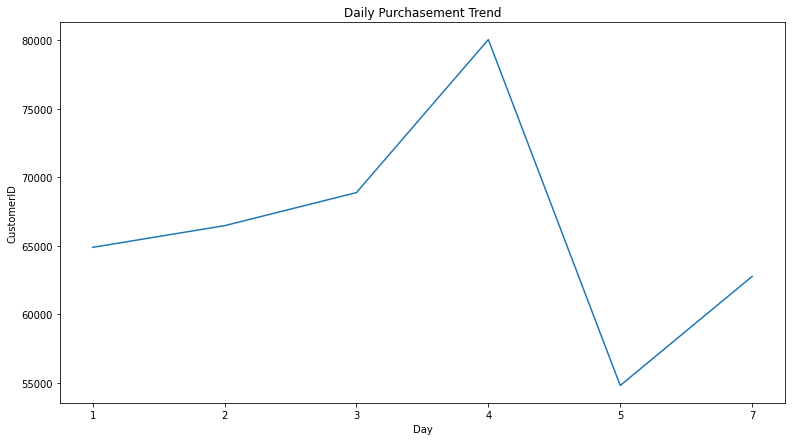

In [ ]:
daily_purchasements = df_eda_d.copy()

_ = plt.figure(figsize=(13, 7))  
_ = plt.title('Daily Purchasement Trend')
_ = sns.lineplot(x = daily_purchasements.index, y = daily_purchasements)
plt.show()

Dari data diatas dapat dilihat bahwa Customer Traffic tertinggi ada pada hari **Kamis**, sementara itu tidak ada Customer Traffic pada hari **Sabtu**

In [ ]:
df_eda['Time'] = pd.to_datetime(df['Time'])

df_eda_t = df_eda.groupby([df_eda['Time'].dt.hour])['CustomerID'].count()

df_eda_t

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Time
6         1
7       379
8      8690
9     21944
10    37997
11    49084
12    72065
13    64026
14    54118
15    45369
16    24089
17    13071
18     2928
19     3321
20      802
Name: CustomerID, dtype: int64

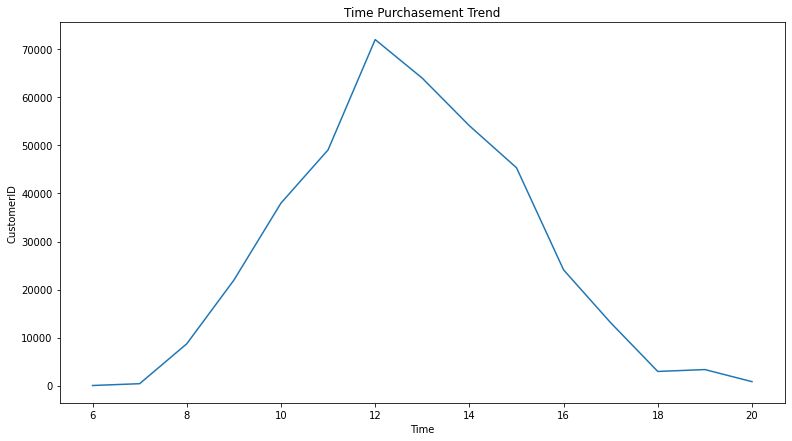

In [ ]:
time_purchasements = df_eda_t.copy()

_ = plt.figure(figsize=(13, 7))  
_ = plt.title('Time Purchasement Trend')
_ = sns.lineplot(x = time_purchasements.index, y = time_purchasements)
plt.show()

Dari data diatas, terlihat jam dengan traffic Customer tinggi antara jam **12 - 14**